# FTE/BTE Experiment for food-101

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, a representation ensembling algorithm based on decision forests (Lifelong Forest) demonstrates forward and backward knowledge transfer of tasks on the food-101 dataset. The original dataset can be found at https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf and https://www.tensorflow.org/datasets/catalog/food101.

### Import necessary packages and modules

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

### Experimental Set-up

food-101 has 101 classes of food with 1000 images each. For the purposes of this experiment, only 100 of those classes are used. The dataset is split into 10 tasks with 10 classes each. 

Each class is then split into 10 batches of 100 images each. Every time the experiment is repeated, the batch used as the test set is shifted.

The remaining 900 images in each class are further split into 10 batches containing 90 images each. Every time the experiment is repeated, the batch used for training each task is shifted. Originally, the first 90 images from each class are used for training, then the second 90 images from each class, third 90 images, and so on.

With 10 batches of test sets and 10 batches of training sets, the number of permutations comes out to 100, so the final errors are averaged across 100 trials and then used to calculate FTE and BTE

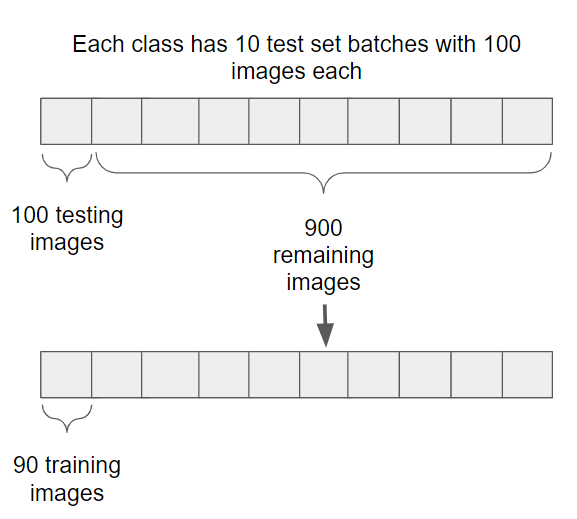

### food-101 Data Generation

The food-101 dataset was downloaded and preprocessed (images were padded and resized) by running the algorithms found in https://github.com/neurodata/LLF_tidy_images. This sectipn of the notebook serves to take those processed images and convert them into numpy arrays that can be read and used by the progressive learning algorithms.

In [ ]:
# Load data set
data_dir = "food-101_dataset/images/" # replace with the path name for wherever the downloaded food-101 images have been stored
foods_sorted = sorted(os.listdir(data_dir))

Start reading the image data into numpy arrays. Only the first 100 out of the 101 sorted food classes will be used in order to make it easier to split up the samples into tasks later on.

This process of initializing each x data array with some images and then concatenating to get the next batch of 10000 images is repeated 10 times, resulting in 10 numpy arrays each containing all the images from 10 of the food-101 classes.

In [ ]:
dict_x = {}
for k in range(10):
    # Initialize data_x* with the first image in the first class, then concatenate to acquire all images from the first class
    food_class = os.listdir(os.path.join(data_dir,foods_sorted[10*k]))
    data_xk = [plt.imread(os.path.join(data_dir, foods_sorted[10*k], food_class[0]))]

    for i in range(1,1000):
            data_xk = np.concatenate([data_xk, [(plt.imread(os.path.join(data_dir, foods_sorted[10*k], food_class[i])))]])

    # Add to the initialized data_x* array until it contains all images from the 10 classes
    # Concatenating more than 10000 images per batch increases the run time by a lot
    for j in range(((k*10)+1),(10*(k+1))):
        food_class = os.listdir(os.path.join(data_dir,foods_sorted[j]))
        for i in range(0,1000):
            data_xk = np.concatenate([data_xk, [(plt.imread(os.path.join(data_dir, foods_sorted[j], food_class[i])))]])
            
    dict_x['data_x' + str(k+1)] = data_xk

In [ ]:
# Combine individual numpy arrays for x data for each batch of 10 classes all into one big numpy array
data_x = np.concatenate([dict_x['data_x1'], dict_x['data_x2'], dict_x['data_x3']])
data_x = np.concatenate([data_x, dict_x['data_x4'], dict_x['data_x5']])
data_x = np.concatenate([data_x, dict_x['data_x6'], dict_x['data_x7']])
data_x = np.concatenate([data_x, dict_x['data_x8'], dict_x['data_x9']])
data_x = np.concatenate([data_x, dict_x['data_x10']])

In [ ]:
# Create y data containing 100 class labels
data_y = np.full((1000), 0, dtype=int)
for i in range(1,100):
    data_y = np.concatenate([data_y, np.full((1000), i, dtype=int)])

### Train the model and perform validation

`which_task`: The task number for which BTE should be calculated

#### run_parallel_exp: 
Wrapper method for the `run_bte_exp` function which declares and trains the model, and performs validation with respect to the test data to compute the error of the model at a particular iteration

In [ ]:
from functions.fte_bte_food101_functions import run_fte_bte_exp

fte = []
bte = []
te = []
accuracies = []

for which_task in range(1,11):
    
    def run_parallel_exp(shift):
    
        df_list = run_fte_bte_exp(data_x, data_y, which_task, shift = shift)

        return df_list

    shifts = np.arange(0,10,1)
    acc = []

    with Pool(8) as p:
        # Paralell processing to run the experiment using a different batch for the test set each time
        acc.append(
            p.map(run_parallel_exp, shifts)
        )
    
    # Average forward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range(which_task):
        for y in range(10):
            for x in range(10):
                acc_x.append(acc[0][x][y]['task_accuracy'][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []
        
    # Calculate and store FTE
    fte.append((1-acc_z[0])/(1-acc_z[-1]))
    
    # Average backward transfer accuracies accross all permutations of testing and training batches for each task
    acc_x = []
    acc_y = []
    acc_z = []
    for z in range((which_task - 1), 10):
        for y in range(10):
            for x in range(10):
                acc_x.append(acc[0][x][y]['task_accuracy'][z])
            acc_y.append(np.mean(acc_x))
            acc_x = []
        acc_z.append(np.mean(acc_y))
        acc_y = []
        
    # Calculate and store accuracies, BTE, and TE
    accuracies.append(acc_z)
    calc_bte = (1-acc_z[0])/([1-a for a in acc_z])
    bte.append(calc_bte)
    te.append([fte[(which_task-1)]*a for a in calc_bte])

### Calculating FTE, BTE, TE, and Accuracy

The forward transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$FTE_n^t (f) := \mathbb{E} [R^t (f(D_n^{t}) )] / \mathbb{E} [R^t (f(D_n^{<t}))]$$

We say an algorithm achieves forward transfer for task $t$ if and only if $FTE_n^t(f) > 1$. Intuitively, this means that the progressive learner has used data associated with past tasks to improve performance on task $t$. 

The backward transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$BTE_n^t (f) := \mathbb{E} [R^t (f(D_n^{<t}) )] / \mathbb{E} [R^t (f(D_n))]$$

We say an algorithm achieves backward transfer for task $t$ if and only if $BTE_n^t(f) > 1$. Intuitively, this means that the progressive learner has used data associated with new tasks to improve performance on previous tasks. 

The transfer efficiency of $f$ for task $t$ given $n$ samples is 
$$TE_n^t (f) := \mathbb{E} [R^t (f(D_n^{t}) )] / \mathbb{E} [R^t (f(D_n))]$$

We say an algorithm has transfer learned for task $t$ with data $D_n$ if and only if $TE_n^t(f) > 1$.

### Plotting FTE, BTE, TE, and Accuracy
Run cell to generate a figure containing 4 plots of the forward transfer efficiency, backward transfer efficiency, transfer efficiency, and accuracy of the Lifelong Classification Forest algorithm. 

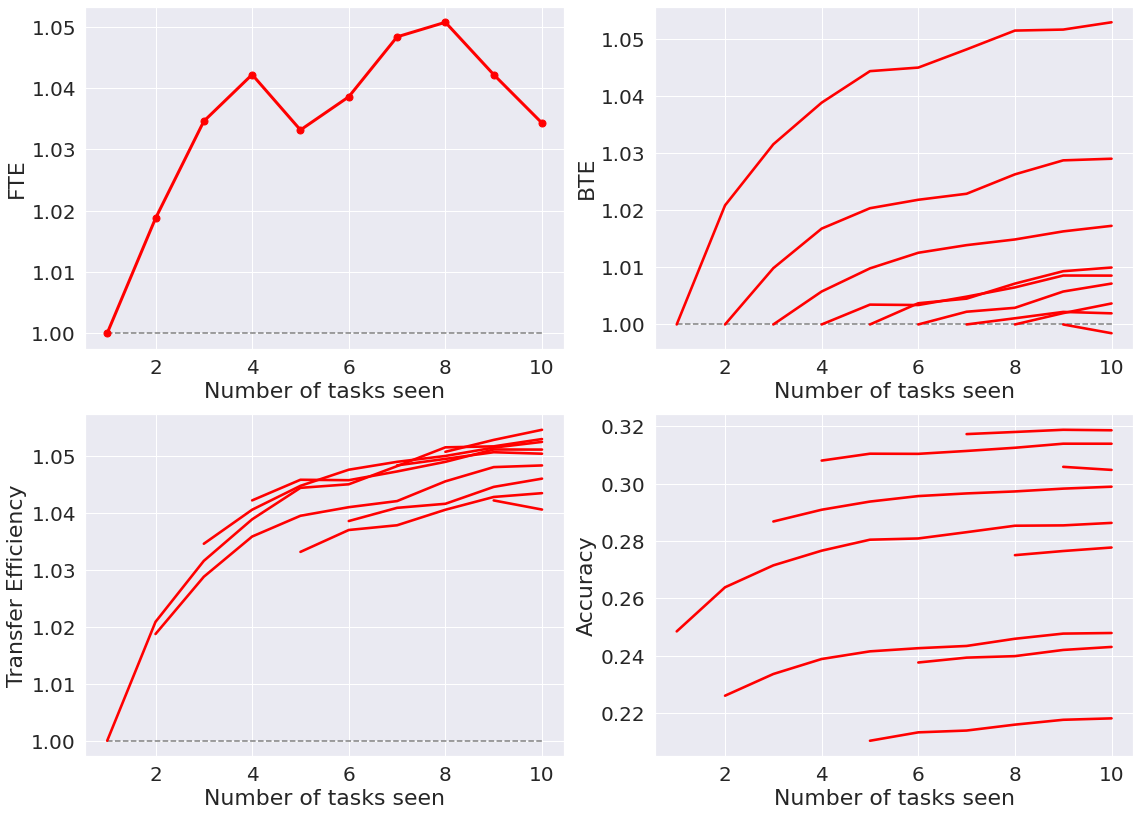

In [5]:
sns.set()

n_tasks=10
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
#c = sns.color_palette(clr, n_colors=len(clr))

fontsize=22
ticksize=20

# Plot FTE

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
#fig.suptitle('ntrees = '+str(ntrees),fontsize=25)
ax[0][0].plot(np.arange(1,n_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('FTE', fontsize=fontsize)

# Plot BTE

for i in range(n_tasks):

    et = np.asarray(bte[i])

    ns = np.arange(i + 1, n_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth = 2.6)
    
ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('BTE', fontsize=fontsize)
#ax[0][1].set_xticks(np.arange(1,10))
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)

# Plot TE

for i in range(n_tasks):

    et = np.asarray(te[i])

    ns = np.arange(i + 1, n_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth = 2.6)
    
ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('Transfer Efficiency', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)

# Plot accuracy

for i in range(n_tasks):
    acc_p = np.asarray(accuracies[i])
    ns = np.arange(i + 1, n_tasks + 1)

    ax[1][1].plot(ns, acc_p , c='red', linewidth = 2.6)
            
#ax[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=22)
ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)